# Finding fast growing firms 2025: Prediction and Classification

**Authors**: Elsa Andera Rodriguez, Petra Ilic

In [5]:
import os
import sys
import warnings
import pyfixest as pf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

import py_helper_functions as da


Import data (output from "firm_growth_data_prep")

In [6]:
data = pd.read_csv("data/clean/bisnode_firms_clean.csv")

Define and create the binary variable.

In [7]:
# Calculate the 20th percentile
percentile_20 = data["sales_mil_log"].quantile(0.20)

# Create binary column: 0 if below 20th percentile, 1 if above
data["growth_binary"] = np.where(data["sales_mil_log"] <= percentile_20, 0, 1)

# Check the distribution
print(f"\nDistribution of binary column:")
print(data["growth_binary"].value_counts())


Distribution of binary column:
growth_binary
1    15228
0     3808
Name: count, dtype: int64


Define helper functions

In [8]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    # Plot loss curve
    sns.lineplot(x=all_coords_copy["thresholds"], y=all_coords_copy["loss"])

    # Vertical line for optimal threshold
    plt.axvline(x=t, linestyle="--")

    # Annotations
    plt.text(
        t - 0.03,
        all_coords_copy["loss"].max() - 0.7,
        f"Best threshold: {round(t, 2)}",
        color=da.color[1],
        rotation=90,
        fontsize=8,
    )
    plt.text(t + 0.06, l, f"{round(l, 2)}", fontsize=8)

    # Labels and limits
    plt.xlabel("Thresholds")
    plt.ylabel("Expected loss")
    plt.xlim(-0.01, 1.01)
    plt.xticks(np.arange(0, 1.1, 0.1))

    # Style
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Plot ROC curve
    sns.lineplot(x=fpr, y=tpr, linewidth=1)

    # Fill area under curve
    plt.fill_between(fpr, tpr, alpha=0.3, color="mediumaquamarine")

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

    # Labels and limits
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Style
    sns.despine()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    # Plot ROC curve
    sns.lineplot(x=all_coords_copy["sp"], y=all_coords_copy["se"])

    # Highlight optimal threshold point
    plt.scatter(sp, se, color="black", s=10)
    plt.text(sp, se + 0.03, f"{round(sp, 2)}, {round(se, 2)}", fontsize=10, ha="center")

    # Fill area under curve
    plt.fill_between(
        all_coords_copy["sp"],
        all_coords_copy["se"],
        alpha=0.3,
        color="mediumaquamarine",
    )

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

    # Labels and limits
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlim(0, 1.01)
    plt.ylim(0, 1.01)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Style
    sns.despine()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()

Define variables

In [9]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "share_eq",
    "subscribed_cap",
]

In [10]:
#financial variables
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

In [11]:
#flag variables
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

In [12]:
#human capital related variables
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

In [13]:
#firms history related variables
firm = ["age", "age2", "new", "ind2_cat", "C(m_region_loc)", "C(urban_m)"]

In [14]:
#interactons for logit and lasso
interactions1 = [
    "ind2_cat*age",
    "ind2_cat*age2",
    "ind2_cat*ceo_age",
    "ind2_cat*foreign_management",
    "ind2_cat*female",
    "ind2_cat*C(urban_m)",
    "ind2_cat*labor_avg_mod",
]

In [15]:
#model setup: simple logit
M1 = ["profit_loss_year_pl",
    "ind2_cat",
]
M2 = ["profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs",
    "curr_liab_bs_flag_high",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "ind2_cat",
]
M3 = firm + engvar 
M4 = (firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
)
M5 = (firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
    + interactions1
)

In [16]:
#logit+ lasso
logit_lasso_vars = (engvar
    + engvar2
    + engvar3
    + hr
    + firm
    + qualityvars
    + interactions1
)

In [17]:
# CART and RF (no interactions, no modified features)
rfvars = rawvars + hr + firm + qualityvars

## Part I: Probablitity prediction

Split data to train and test.

In [21]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [22]:
print("Total")
print(data["growth_binary"].value_counts(normalize=True))
print("Train")
print(data_train["growth_binary"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["growth_binary"].value_counts(normalize=True))


Total
growth_binary
1    0.799958
0    0.200042
Name: proportion, dtype: float64
Train
growth_binary
1    0.803257
0    0.196743
Name: proportion, dtype: float64
Holdout
growth_binary
1    0.786765
0    0.213235
Name: proportion, dtype: float64


### Models

In [58]:
# specify 5 fold cross-validation method
k = KFold(n_splits=5, shuffle=True, random_state=42)

### a) Logit models

In [59]:
# set up x variables
logit_model_vars = [M1, M2, M3, M4, M5]

In [ ]:
# set up logit model object
C_value_logit = [1e20]

In [26]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "growth_binary~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [27]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.377348,0.372059,0.341080,0.291793,0.299066
1,0.370293,0.365542,0.340655,0.298497,0.300850
2,0.375649,0.370990,0.340683,0.291992,0.296544
3,0.375460,0.371647,0.340439,0.293848,0.300318
4,0.384370,0.379524,0.353250,0.300688,0.306466


### b) Logit + LASSO


In [28]:
model_equation = "growth_binary~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

In [ ]:
# normalize X vars
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

In [ ]:
# set parameters
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

In [ ]:
# initialize and fit logit lasso
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

In [ ]:
# CV-fold RMSEs
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000821,0.380480
1,0.046416,0.001768,0.341887
2,0.021544,0.003810,0.327054
3,0.010000,0.008209,0.316744
4,0.004642,0.017685,0.307849
5,0.002154,0.038101,0.302144
6,0.001000,0.082086,0.297809
7,0.000464,0.176848,0.295723
8,0.000215,0.381008,0.294889
9,0.000100,0.820856,0.294544


In [ ]:
# save best lambda index
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

In [ ]:
# extract CV test RMSE for the lasso with best lambda
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

### Performance

AUC, Calibration Curve, Confusion Matrix, ROC

In [ ]:
# Calculate AUC for logits folds
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "growth_binary~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

In [ ]:
# for lasso
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

Put a summary frame together

In [37]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [60]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

72

In [ ]:
len([i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0])

72

In [62]:
summary.round(3)

,Number of Coefficients,CV RMSE,CV AUC
M1,3,0.377,0.633
M2,10,0.372,0.681
M3,24,0.343,0.816
M4,68,0.295,0.917
M5,76,0.301,0.911
LASSO,72,0.295,0.918


**Best Model**: 

M4 and the LASSO model have the same CV RMSE and have practicallly the same CV AUC. Therefore, we will pick M4 as the best model because it is less complex (has 68 coeffients rather than 72).

Take best model (M4) and estimate RMSE on holdout:

In [39]:
best_logit = logit_models["M4"]
model_equation = "growth_binary~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

In [40]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["growth_binary"]), 3)

np.float64(0.298)

calibration curve

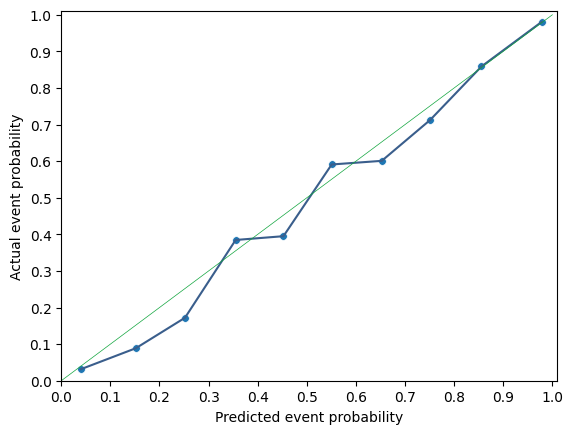

In [41]:
da.create_calibration_plot(
    data_holdout,
    prob_var="best_logit_pred_proba",
    actual_var="growth_binary",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)

In [42]:
#confusion table
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (growth_binary less than 20%): ", counts[0])
print(values[1], " (growth_binary above 20%): ", counts[1])

0.0  (growth_binary less than 20%):  578
1.0  (growth_binary above 20%):  3230


In [43]:
cm_object1 = confusion_matrix(
    data_holdout["growth_binary"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actul no growth_binary", "Actual growth_binary"],
    columns=["Predicted no growth_binary", "Predicted growth_binary"],
)
cm1

,Predicted no growth_binary,Predicted growth_binary
Actul no growth_binary,457,355
Actual growth_binary,121,2875


In [44]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["growth_binary"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actul no growth_binary", "Actual growth_binary"],
    columns=["Predicted no growth_binary", "Predicted growth_binary"],
)
cm1b

,Predicted no growth_binary,Predicted growth_binary
Actul no growth_binary,457,355
Actual growth_binary,121,2875


In [45]:
mean_predicted_growth_binary_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_growth_binary_prob, 3)

np.float64(0.794)

In [46]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_growth_binary_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["growth_binary"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul no growth_binary", "Actual growth_binary"],
    columns=["Predicted no growth_binary", "Predicted growth_binary"],
)
cm2

,Predicted no growth_binary,Predicted growth_binary
Actul no growth_binary,697,115
Actual growth_binary,551,2445


visualize roc (comparing multuple thresholds)

In [47]:
thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["growth_binary"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [48]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

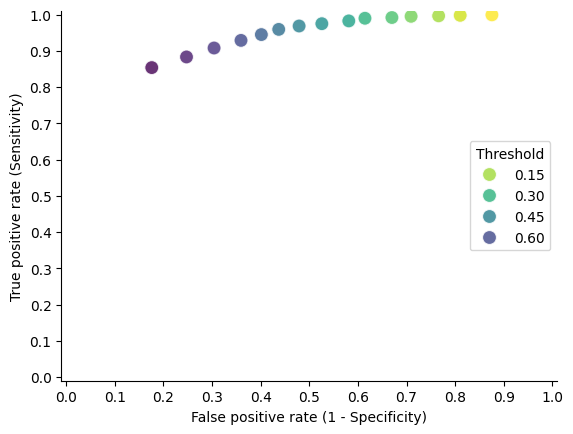

In [49]:
scatter = sns.scatterplot(
    data=tpr_fpr_for_thresholds,
    x="false_positive_rates",
    y="true_positive_rates",
    hue="thresholds",
    palette="viridis_r",
    s=100,
    alpha=0.8,
)

plt.xlabel("False positive rate (1 - Specificity)")
plt.ylabel("True positive rate (Sensitivity)")
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.legend(title="Threshold", loc="center right")
sns.despine()
plt.show()

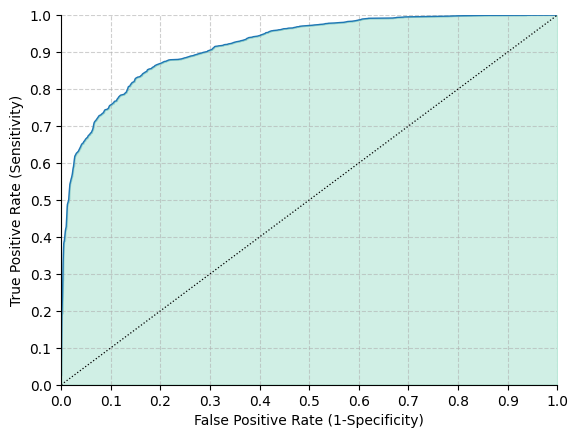

In [50]:
create_roc_plot(data_holdout["growth_binary"], data_holdout["best_logit_pred_proba"])

## Part II: Classification

Define the loss function.

In [77]:
FP = 10
FN = 1
cost = FN / FP

In [78]:
prevelance = y_train.sum() / len(y_train)

Look for the optimal classification threshold and calculate expected loss.

In [79]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("growth_binary ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["growth_binary"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [80]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()


In [81]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,inf,0.971711,0.802797,0.791133
1,M2,inf,0.983110,0.802928,0.791461
2,M3,0.875438,0.899530,0.608485,0.619048
3,M4,0.883107,0.887221,0.349618,0.340230
4,M5,0.877893,0.875495,0.367678,0.372742
5,LASSO,0.895117,0.907420,0.349683,0.342529


**Best Model**: M4 has the smallest average expected loss.

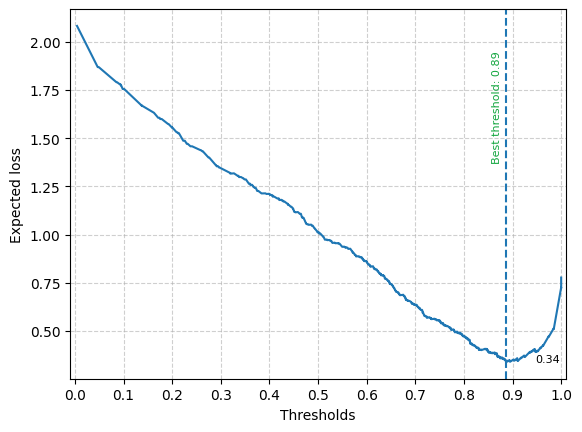

In [82]:
model_to_plot = "M4"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

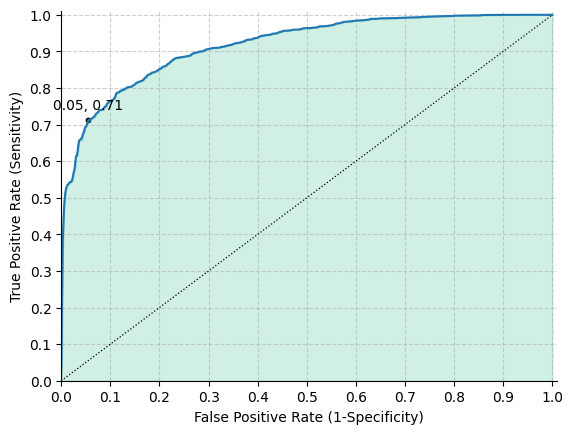

In [83]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)